In [1]:
import pandas as pd
import json
import numpy as np

from itertools import product
from tqdm.notebook import tqdm

In [2]:
with open('telco_directed.json') as f:
    data= json.load(f)

In [3]:
#edge_list
location_list = list(product(data['locations'], data['locations']))

values = np.array(data['data'])

df = pd.DataFrame()
df['src'] = [i[0] for i in location_list]
df['dst'] = [i[1] for i in location_list]

for idx, date in enumerate(data['dates']):
    df[date] = values[:,idx]

<ipython-input-3-9f11851630c9>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[date] = values[:,idx]


In [4]:
df = df.melt(id_vars=['src','dst'],var_name='day')

In [5]:
df['inversed'] = 1 / df.value
df.inversed = df.inversed / np.max(df.inversed[df.inversed != np.inf])

In [6]:
import networkx as nx

In [7]:
df

,src,dst,day,value,inversed
0,Aabenraa,Aabenraa,2020-02-01 00:00:00,323162.099102,0.000015
1,Aabenraa,Aalborg,2020-02-01 00:00:00,405.268442,0.012338
2,Aabenraa,Albertslund,2020-02-01 00:00:00,0.000000,inf
3,Aabenraa,Allerød,2020-02-01 00:00:00,0.000000,inf
4,Aabenraa,Assens,2020-02-01 00:00:00,690.133217,0.007245
...,...,...,...,...,...
4955659,Ærø,Vesthimmerland,2021-06-30 00:00:00,0.000000,inf
4955660,Ærø,Viborg,2021-06-30 00:00:00,0.000000,inf
4955661,Ærø,Vordingborg,2021-06-30 00:00:00,0.000000,inf
4955662,Ærø,Århus,2021-06-30 00:00:00,0.000000,inf


In [8]:
days, dist = [], []
for day in df.day.unique():
    print(day)
    
    subset = df[df.day == day].copy()
    subset = subset[['src', 'dst', 'inversed']]
    #subset.drop('day', inplace=True, axis=1)
    
    #subset_non_zero = subset #subset[subset.value != 0].copy()
    #subset_non_zero.value = 1/subset_non_zero.value
    G = nx.DiGraph()
    G.add_weighted_edges_from(subset.values)
    dist.append(nx.average_shortest_path_length(G, weight="weight"))
    days.append(day)

2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-07 00:00:00
2020-02-08 00:00:00
2020-02-09 00:00:00
2020-02-10 00:00:00
2020-02-11 00:00:00
2020-02-12 00:00:00
2020-02-13 00:00:00
2020-02-14 00:00:00
2020-02-15 00:00:00
2020-02-16 00:00:00
2020-02-17 00:00:00
2020-02-18 00:00:00
2020-02-19 00:00:00
2020-02-20 00:00:00
2020-02-21 00:00:00
2020-02-22 00:00:00
2020-02-23 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-26 00:00:00
2020-02-27 00:00:00
2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00


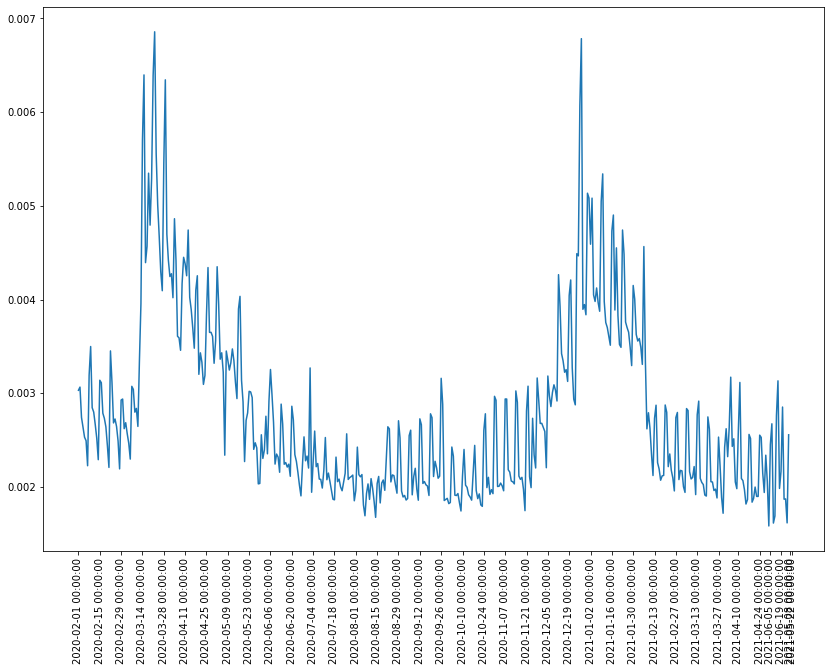

In [9]:
import matplotlib.pylab as plt
%matplotlib inline
dist = np.array(dist)
days = np.array(days)
#plt.hist(dist[dist < 1])
plt.figure(figsize=(14, 10))
plt.plot(days[dist < 1], dist[dist < 1])
plt.xticks(days[::14], rotation=90);

In [10]:
mun = pd.read_csv('../data/Municipality_cases_time_series.csv', sep=';')
mun.set_index('SampleDate', inplace=True)

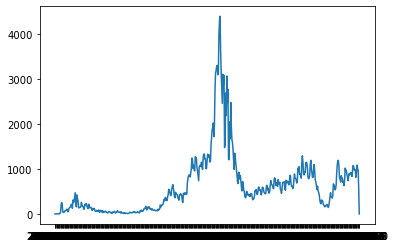

In [11]:
mun['total'] = mun.sum(axis=1)
plt.plot(mun.index, mun.total)
exclude_days = days[dist > 99]

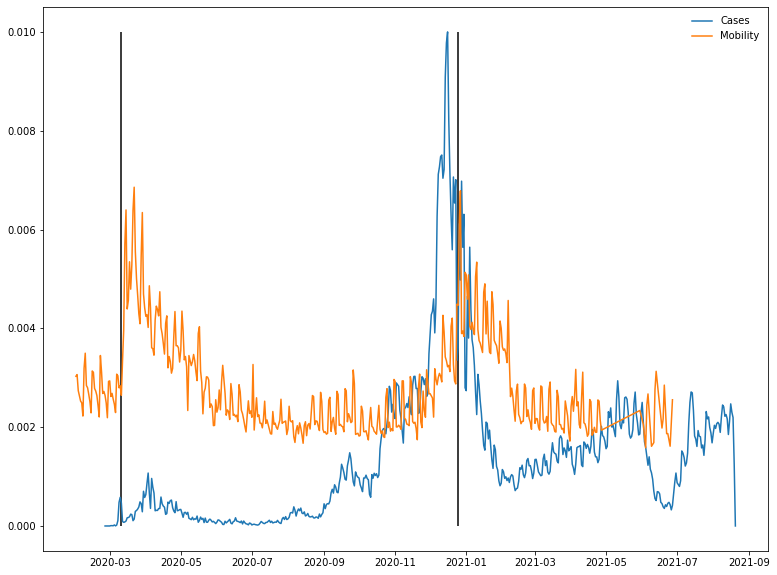

In [12]:
plt.figure(figsize=(13, 10))
plt.plot(pd.to_datetime(mun.index), mun.total / max(mun.total) / 1e2)
plt.plot(pd.to_datetime(days[dist < 99]), dist[dist < 99])
plt.legend(('Cases', 'Mobility'), loc='best', frameon=False)
doi = pd.to_datetime(['2020-03-11', '2020-12-25'])
plt.vlines(doi, 0, 0.01, color='k');

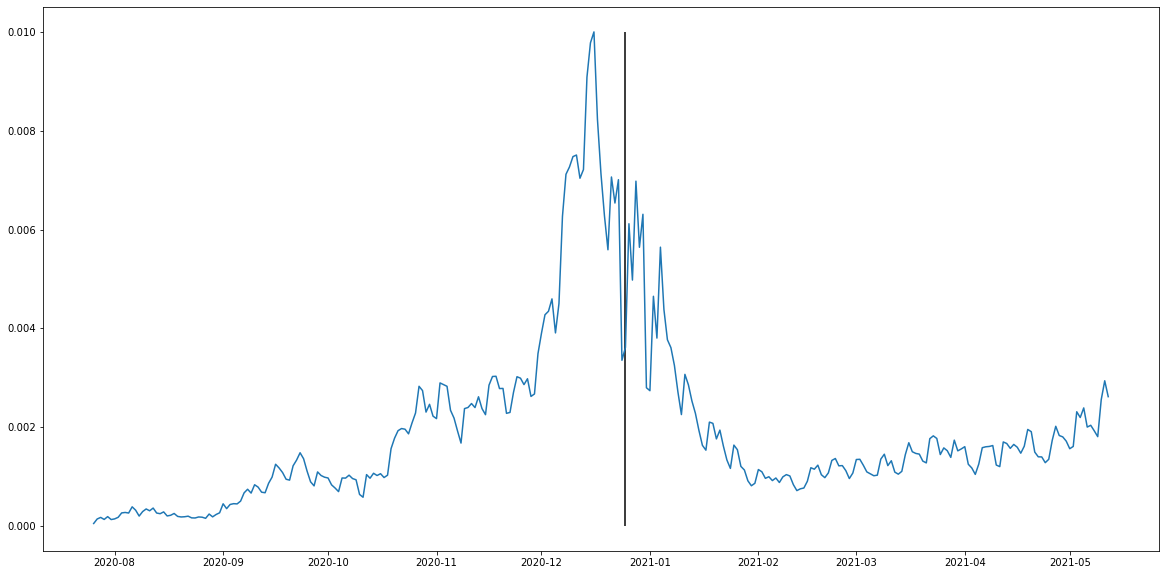

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(pd.to_datetime(mun.index)[150:-100], mun.total[150:-100] / max(mun.total) / 1e2)
doi = pd.to_datetime(['2020-03-11', '2020-12-25'])
plt.vlines(doi[1], 0, 0.01, color='k');

In [14]:
adm = pd.read_csv('../data/Newly_admitted_over_time.csv', sep=';')

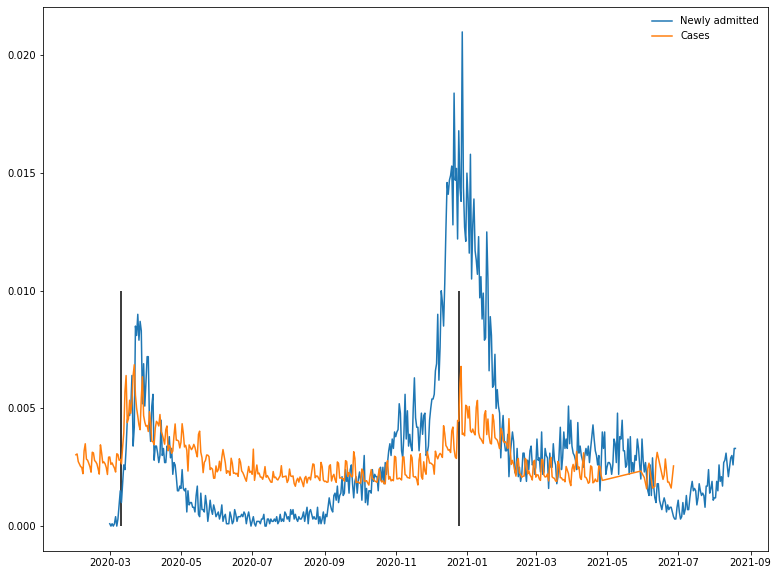

In [15]:
plt.figure(figsize=(13, 10))
plt.plot(pd.to_datetime(adm.Dato), adm.Total / 1e4)
plt.plot(pd.to_datetime(days[dist < 99]), dist[dist < 99])
plt.legend(('Newly admitted', 'Cases', 'Mobility'), loc='best', frameon=False)
plt.vlines(doi, 0, 0.01, color='k');

In [16]:
import datetime
doi_7d = doi + datetime.timedelta(days=7)

In [17]:
def get_average(time, series, lag, t0):
    time = pd.to_datetime(time)
    t1 = t0 + datetime.timedelta(days=lag)
    if lag > 0:
        idx = (time <= t1) & (time >= t0)
    else:
        idx = (time >= t1) & (time <= t0)
    return np.median(series[idx])

def get_perc(time, series, lags, t0):
    a = get_average(time, series, lags[0], t0)
    b = get_average(time, series, lags[1], t0)
    return (a-b)/a*100

print('Mobility(1):', get_perc(days, dist, (-7, 7), doi[0]))
print('Case(1):', get_perc(mun.index, mun.total, (7, 14), doi[0]))

print('Mobility(2):', get_perc(days, dist, (-7, 7), doi[1]))
print('Case(2):', get_perc(mun.index, mun.total, (7, 14), doi[1]))

Mobility(1): -64.59582610421081
Case(1): -27.73109243697479
Mobility(2): -30.51306074603219
Case(2): 17.45009658725048


In [21]:
import pandas as pd

In [73]:
zip1 = pd.read_csv('all_zipcodes.csv', index_col=0)

for direction in ['orig', 'dest']:
    zip1[direction] = zip1[direction].str.replace('-', ' ')
    zip1[direction] = zip1[direction].str.replace('Aarhus', 'Århus')
    zip1[direction] = zip1[direction].str.replace('Nordfyn', 'Nordfyns')

In [89]:
df_merged = pd.merge(df,zip1, left_on=["src","dst"], right_on=["orig","dest"])
df_merged.drop(columns=["orig", "dest"], inplace=True)

In [163]:
df_merged["bin"] = pd.cut(df_merged["duration"],bins=(-1,900,4500,9000,50000),labels=("15 min", "1.5 h", "2.5 h", "2.5+ h"))
df_merged

,src,dst,day,value,inversed,distance,duration,bin
0,Aabenraa,Aabenraa,2020-02-01 00:00:00,323162.099102,0.000015,0.0,0.0,15 min
1,Aabenraa,Aabenraa,2020-02-02 00:00:00,295328.638037,0.000017,0.0,0.0,15 min
2,Aabenraa,Aabenraa,2020-02-03 00:00:00,388974.404547,0.000013,0.0,0.0,15 min
3,Aabenraa,Aabenraa,2020-02-04 00:00:00,404667.087491,0.000012,0.0,0.0,15 min
4,Aabenraa,Aabenraa,2020-02-05 00:00:00,407815.830703,0.000012,0.0,0.0,15 min
...,...,...,...,...,...,...,...,...
4955659,Ærø,Ærø,2021-06-26 00:00:00,55759.730066,0.000090,0.0,0.0,15 min
4955660,Ærø,Ærø,2021-06-27 00:00:00,59839.710315,0.000084,0.0,0.0,15 min
4955661,Ærø,Ærø,2021-06-28 00:00:00,61501.924490,0.000081,0.0,0.0,15 min
4955662,Ærø,Ærø,2021-06-29 00:00:00,89457.344713,0.000056,0.0,0.0,15 min


In [164]:
grouped = df_merged.groupby('bin')

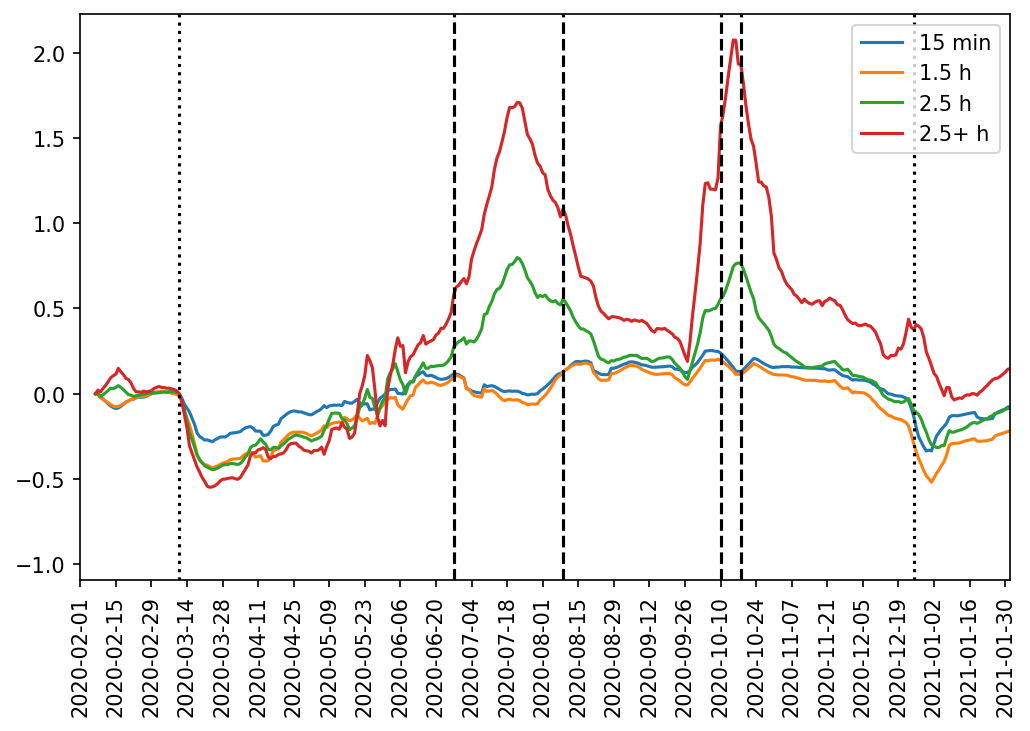

In [199]:
fig, ax = plt.subplots(figsize=(8,5), dpi=150)

for name, group in grouped:
    summed_group = group.groupby("day").sum().reset_index()
    baseline = summed_group['value'][0:7].mean()
    summed_group['mobility_change'] = (summed_group['value']-baseline)/baseline
    summed_group = summed_group.set_index('day').rolling(window=7).mean()
    ax.plot(pd.to_datetime(summed_group.index), summed_group['mobility_change'], label=name)
plt.axvline(pd.to_datetime('2020-03-11'), linestyle='dotted', color='black')
plt.axvline(pd.to_datetime('2020-12-25'), linestyle='dotted', color='black')

plt.axvline(pd.to_datetime('2020-06-27'), linestyle='dashed', color='black')
plt.axvline(pd.to_datetime('2020-08-09'), linestyle='dashed', color='black')

plt.axvline(pd.to_datetime('2020-10-10'), linestyle='dashed', color='black')
plt.axvline(pd.to_datetime('2020-10-18'), linestyle='dashed', color='black')

plt.legend()
plt.xticks(summed_group.index[::14], rotation=90)
plt.xlim(pd.to_datetime(('2020-2', '2021-2')))
plt.show();

In [219]:
baseline = pd.DataFrame(dist)[0:7].mean()
ts = (pd.DataFrame(dist)-baseline)/baseline
ts = ts.set_index(rolled_group.index).rolling(window=7).mean()

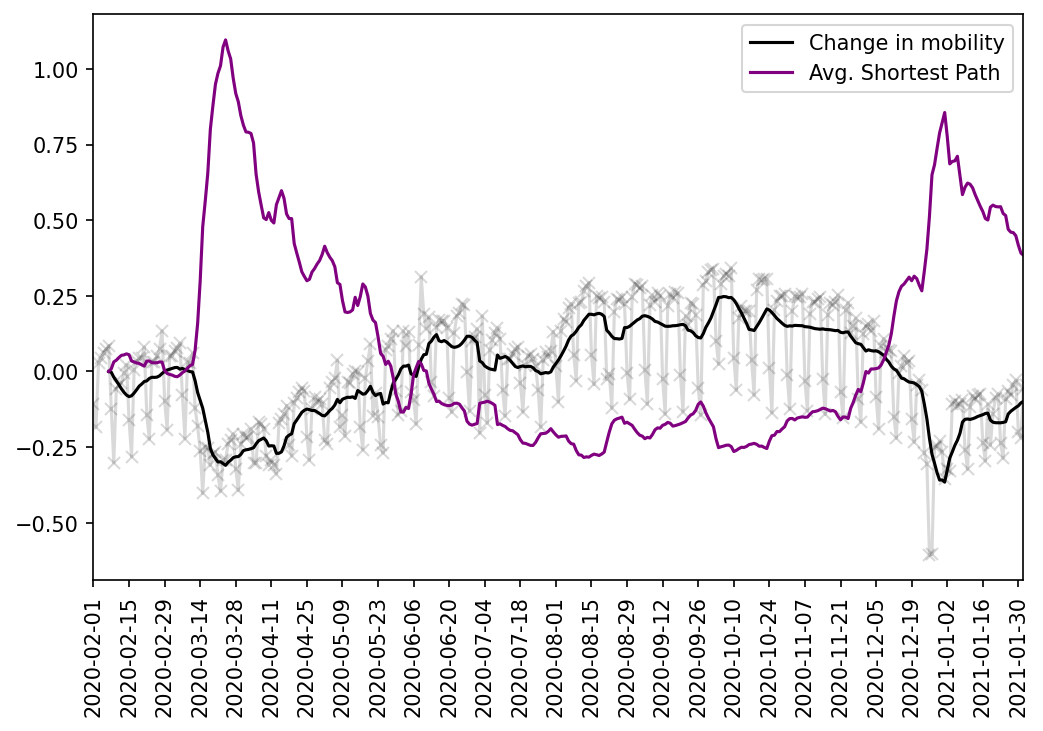

In [223]:
fig, ax = plt.subplots(figsize=(8,5), dpi=150)

summed_group = df_merged.groupby("day").sum().reset_index()
baseline = summed_group['value'][0:7].mean()
summed_group['mobility_change'] = (summed_group['value']-baseline)/baseline
rolled_group = summed_group.set_index('day').rolling(window=7).mean()
ax.plot(pd.to_datetime(rolled_group.index), rolled_group['mobility_change'], color='black', label='Change in mobility')
ax.plot(pd.to_datetime(rolled_group.index), summed_group.set_index('day')['mobility_change'], alpha=0.15, color='black', zorder=0, marker='x')

ax.plot(pd.to_datetime(rolled_group.index), ts, color='purple', label='Avg. Shortest Path')

#plt.axvline(pd.to_datetime('2020-03-11'), linestyle='dotted', color='black')
#plt.axvline(pd.to_datetime('2020-12-25'), linestyle='dotted', color='black')

#plt.axvline(pd.to_datetime('2020-06-27'), linestyle='dashed', color='black')
#plt.axvline(pd.to_datetime('2020-08-09'), linestyle='dashed', color='black')

#plt.axvline(pd.to_datetime('2020-10-10'), linestyle='dashed', color='black')
#plt.axvline(pd.to_datetime('2020-10-18'), linestyle='dashed', color='black')


plt.legend()
plt.xticks(pd.to_datetime(rolled_group.index[::14]), rotation=90)
plt.xlim(pd.to_datetime(('2020-2', '2021-2')))
plt.show();

In [ ]:
shortest_path.loc[shortest_path['day'].isin('2020-'